In [ ]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4628905.23it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 132953.68it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1276576.72it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4086342.51it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
def train_with_RDrop(model: nn.Module,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0,
          alpha: int=1)-> List:
    model.train()

    train_losses = []
    train_counter = []

    for batch_idx, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        output1 = model(images)
        output2 = model(images)
        loss = rdrop_loss(output1, output2, targets, alpha)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if torch.isnan(loss).any():
          print("NaN loss detected, stopping training.")
          break

        if batch_idx % 10 == 0:
          train_losses.append(loss.item())
          train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

        if batch_idx % 100 == 0:
          print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')

    return train_losses, train_counter

def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0)-> List:
    model.train()

    train_losses = []
    train_counter = []


    for batch_idx, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
          train_losses.append(loss.item())
          train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

        if batch_idx % 100 == 0:
          print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')

    return train_losses, train_counter

def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:

    model.eval()

    test_losses = []
    test_counter = []
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        output = model(images)
        test_loss += loss_fn(output, targets).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(targets.data.view_as(pred)).sum()

      test_loss /= len(test_loader)
      test_losses.append(test_loss)
      test_counter.append(len(train_loader.dataset)*epoch)

    print(f'Test result on epoch {epoch}: Avg loss is {test_loss:.3f}, Accuracy: {100.*correct/len(test_loader.dataset):.3f}%')

    return test_losses, test_counter

In [ ]:
# def compute_kl_loss(p, q, pad_mask=None):
#     p_loss = F.kl_div(F.log_softmax(p, dim=-1), F.softmax(q, dim=-1), reduction='batchmean')
#     q_loss = F.kl_div(F.log_softmax(q, dim=-1), F.softmax(p, dim=-1), reduction='batchmean')
#     loss = (p_loss + q_loss) / 2
#     return loss

def compute_kl_loss(p, q, pad_mask=None):
    eps = 1e-8
    p = F.log_softmax(p, dim=-1)
    q = F.softmax(q, dim=-1)
    q = torch.clamp(q, min=eps)
    p_loss = F.kl_div(p, q, reduction='batchmean')
    q_loss = F.kl_div(F.log_softmax(q, dim=-1), F.softmax(p, dim=-1), reduction='batchmean')
    loss = (p_loss + q_loss) / 2
    return loss

def rdrop_loss(output1, output2, target, alpha=1.0):
    ce_loss = 0.5 * (F.nll_loss(output1, target) + F.nll_loss(output2, target))
    kl_loss = compute_kl_loss(output1, output2)
    loss = ce_loss + alpha * kl_loss
    return loss

In [ ]:
def train_std_model(model, optimizer, max_epoch, train_loss_f, test_loss_f):
  train_losses = []
  train_counter = []
  test_losses = []
  test_counter = []

  start = time.time()
  model = model.to(device)
  for epoch in range(1, max_epoch + 1):
    train_loss, train_count = train(model, train_loss_f, optimizer, train_loader, epoch)
    test_loss, test_count = test(model, test_loss_f, test_loader, epoch)
    train_losses += train_loss
    train_counter += train_count
    test_losses += test_loss
    test_counter += test_count
  end = time.time()
  print(f'Finished Training after {end-start} s ')

  fig = plt.figure(figsize=(12,5))
  plt.plot(train_counter, train_losses, color='blue')
  # plt.scatter(test_counter, test_losses, color='red')
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel('Number of training examples seen')
  plt.ylabel('Loss')

def train_rd_model(model, optimizer, max_epoch, test_loss_f, alpha):
  train_losses = []
  train_counter = []
  test_losses = []
  test_counter = []

  start = time.time()
  model = model.to(device)
  for epoch in range(1, max_epoch + 1):
    train_loss, train_count = train_with_RDrop(model, optimizer, train_loader, epoch, alpha)
    test_loss, test_count = test(model, test_loss_f, test_loader, epoch)
    train_losses += train_loss
    train_counter += train_count
    test_losses += test_loss
    test_counter += test_count
  end = time.time()
  print(f'Finished Training after {end-start} s ')

  fig = plt.figure(figsize=(12,5))
  plt.plot(train_counter, train_losses, color='blue')
  # plt.scatter(test_counter, test_losses, color='red')
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel('Number of training examples seen')
  plt.ylabel('Loss')

In [ ]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv = nn.Conv2d(1, 3, kernel_size=5)
    self.fc1 = nn.Linear(432, 128)
    self.fc2 = nn.Linear(128, 10)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv(x), 2))
    x = x.view(-1, 432)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return F.log_softmax(x,-1)

class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)

Epoch 1: [0/60000] Loss: 2.324
Epoch 1: [6400/60000] Loss: 0.711
Epoch 1: [12800/60000] Loss: 0.407
Epoch 1: [19200/60000] Loss: 0.168
Epoch 1: [25600/60000] Loss: 0.237
Epoch 1: [32000/60000] Loss: 0.210
Epoch 1: [38400/60000] Loss: 0.250
Epoch 1: [44800/60000] Loss: 0.144
Epoch 1: [51200/60000] Loss: 0.233
Epoch 1: [57600/60000] Loss: 0.100
Test result on epoch 1: Avg loss is 0.117, Accuracy: 96.200%
Epoch 2: [0/60000] Loss: 0.211
Epoch 2: [6400/60000] Loss: 0.065
Epoch 2: [12800/60000] Loss: 0.199
Epoch 2: [19200/60000] Loss: 0.067
Epoch 2: [25600/60000] Loss: 0.263
Epoch 2: [32000/60000] Loss: 0.189
Epoch 2: [38400/60000] Loss: 0.135
Epoch 2: [44800/60000] Loss: 0.072
Epoch 2: [51200/60000] Loss: 0.225
Epoch 2: [57600/60000] Loss: 0.115
Test result on epoch 2: Avg loss is 0.086, Accuracy: 97.120%
Epoch 3: [0/60000] Loss: 0.189
Epoch 3: [6400/60000] Loss: 0.047
Epoch 3: [12800/60000] Loss: 0.081
Epoch 3: [19200/60000] Loss: 0.048
Epoch 3: [25600/60000] Loss: 0.261
Epoch 3: [32000/60

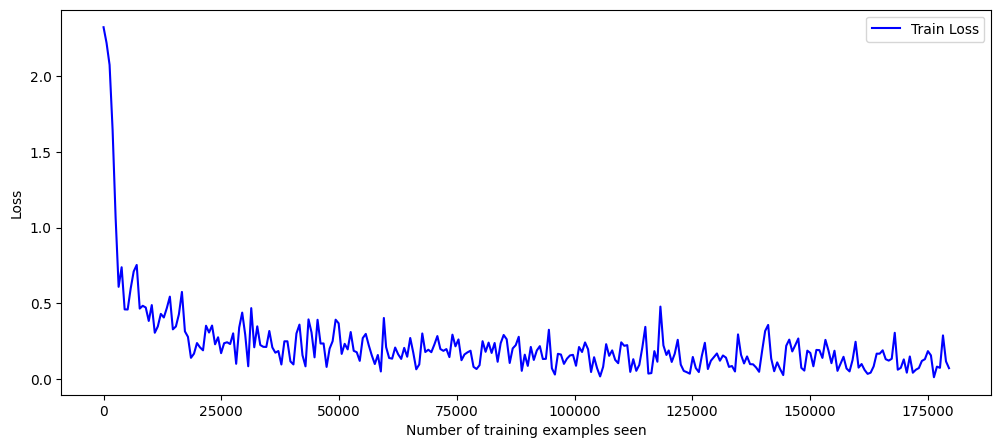

In [ ]:
# SIMPLE CNN WITHOUT RDROP
model = SimpleCNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
max_epochs = 3
train_std_model(model, optimizer, max_epochs, F.nll_loss, F.nll_loss)

Epoch 1: [0/60000] Loss: 2.305
Epoch 1: [6400/60000] Loss: 1.405
Epoch 1: [12800/60000] Loss: 1.106
Epoch 1: [19200/60000] Loss: 1.151
Epoch 1: [25600/60000] Loss: 0.994
Epoch 1: [32000/60000] Loss: 1.017
Epoch 1: [38400/60000] Loss: 0.981
Epoch 1: [44800/60000] Loss: 0.939
Epoch 1: [51200/60000] Loss: 0.993
Epoch 1: [57600/60000] Loss: 0.913
Test result on epoch 1: Avg loss is 0.255, Accuracy: 94.890%
Epoch 2: [0/60000] Loss: 0.991
Epoch 2: [6400/60000] Loss: 0.931
Epoch 2: [12800/60000] Loss: 0.975
Epoch 2: [19200/60000] Loss: 1.029
Epoch 2: [25600/60000] Loss: 0.872
Epoch 2: [32000/60000] Loss: 0.918
Epoch 2: [38400/60000] Loss: 0.901
Epoch 2: [44800/60000] Loss: 0.992
Epoch 2: [51200/60000] Loss: 0.935
Epoch 2: [57600/60000] Loss: 0.937
Test result on epoch 2: Avg loss is 0.173, Accuracy: 96.280%
Epoch 3: [0/60000] Loss: 0.876
Epoch 3: [6400/60000] Loss: 0.932
Epoch 3: [12800/60000] Loss: 0.861
Epoch 3: [19200/60000] Loss: 0.845
Epoch 3: [25600/60000] Loss: 0.867
Epoch 3: [32000/60

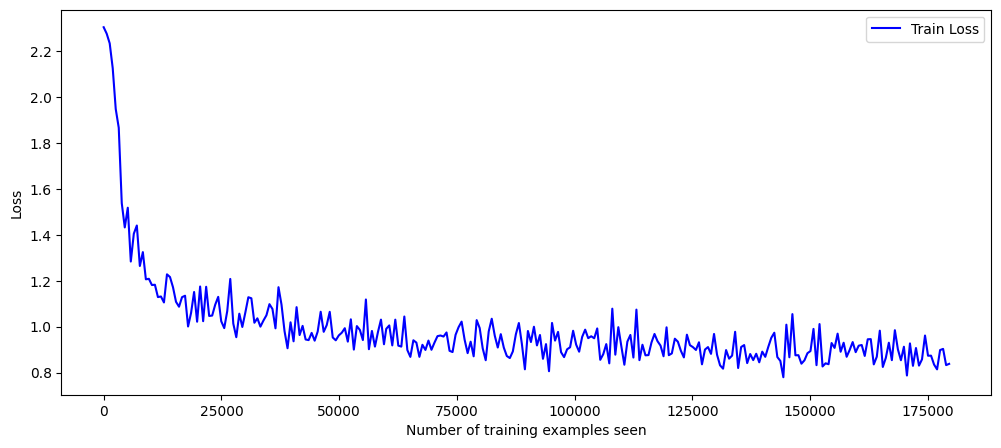

In [ ]:
# SIMPLE CNN WITH RDROP alpha = 1
model = SimpleCNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
max_epochs = 3
train_rd_model(model, optimizer, max_epochs, F.nll_loss, 1)

Epoch 1: [0/60000] Loss: 2.357
Epoch 1: [6400/60000] Loss: 1.601
Epoch 1: [12800/60000] Loss: 1.524
Epoch 1: [19200/60000] Loss: 1.472
Epoch 1: [25600/60000] Loss: 1.430
Epoch 1: [32000/60000] Loss: 1.425
Epoch 1: [38400/60000] Loss: 1.423
Epoch 1: [44800/60000] Loss: 1.356
Epoch 1: [51200/60000] Loss: 1.356
Epoch 1: [57600/60000] Loss: 1.407
Test result on epoch 1: Avg loss is 0.791, Accuracy: 94.000%
Epoch 2: [0/60000] Loss: 1.361
Epoch 2: [6400/60000] Loss: 1.359
Epoch 2: [12800/60000] Loss: 1.386
Epoch 2: [19200/60000] Loss: 1.287
Epoch 2: [25600/60000] Loss: 1.329
Epoch 2: [32000/60000] Loss: 1.365
Epoch 2: [38400/60000] Loss: 1.286
Epoch 2: [44800/60000] Loss: 1.270
Epoch 2: [51200/60000] Loss: 1.324
Epoch 2: [57600/60000] Loss: 1.356
Test result on epoch 2: Avg loss is 0.731, Accuracy: 95.550%
Epoch 3: [0/60000] Loss: 1.369
Epoch 3: [6400/60000] Loss: 1.347
Epoch 3: [12800/60000] Loss: 1.358
Epoch 3: [19200/60000] Loss: 1.414
Epoch 3: [25600/60000] Loss: 1.410
Epoch 3: [32000/60

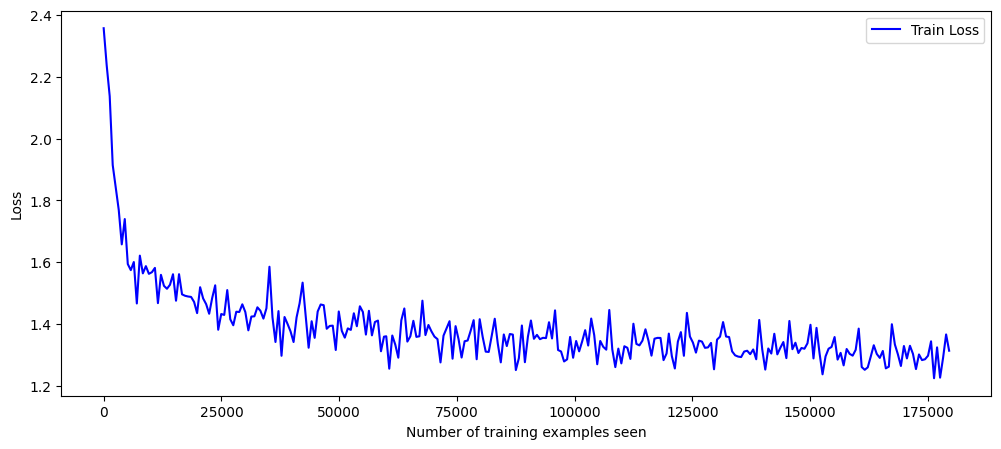

In [ ]:
# SIMPLE CNN WITH RDROP alpha = 2
model = SimpleCNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
max_epochs = 3
train_rd_model(model, optimizer, max_epochs, F.nll_loss, 2)

Epoch 1: [0/60000] Loss: 2.422
Epoch 1: [6400/60000] Loss: 1.678
Epoch 1: [12800/60000] Loss: 1.680
Epoch 1: [19200/60000] Loss: 1.653
Epoch 1: [25600/60000] Loss: 1.576
Epoch 1: [32000/60000] Loss: 1.603
Epoch 1: [38400/60000] Loss: 1.620
Epoch 1: [44800/60000] Loss: 1.621
Epoch 1: [51200/60000] Loss: 1.550
Epoch 1: [57600/60000] Loss: 1.515
Test result on epoch 1: Avg loss is 1.063, Accuracy: 93.940%
Epoch 2: [0/60000] Loss: 1.561
Epoch 2: [6400/60000] Loss: 1.531
Epoch 2: [12800/60000] Loss: 1.567
Epoch 2: [19200/60000] Loss: 1.458
Epoch 2: [25600/60000] Loss: 1.600
Epoch 2: [32000/60000] Loss: 1.578
Epoch 2: [38400/60000] Loss: 1.496
Epoch 2: [44800/60000] Loss: 1.483
Epoch 2: [51200/60000] Loss: 1.474
Epoch 2: [57600/60000] Loss: 1.503
Test result on epoch 2: Avg loss is 1.053, Accuracy: 95.490%
Epoch 3: [0/60000] Loss: 1.574
Epoch 3: [6400/60000] Loss: 1.504
Epoch 3: [12800/60000] Loss: 1.483
Epoch 3: [19200/60000] Loss: 1.522
Epoch 3: [25600/60000] Loss: 1.470
Epoch 3: [32000/60

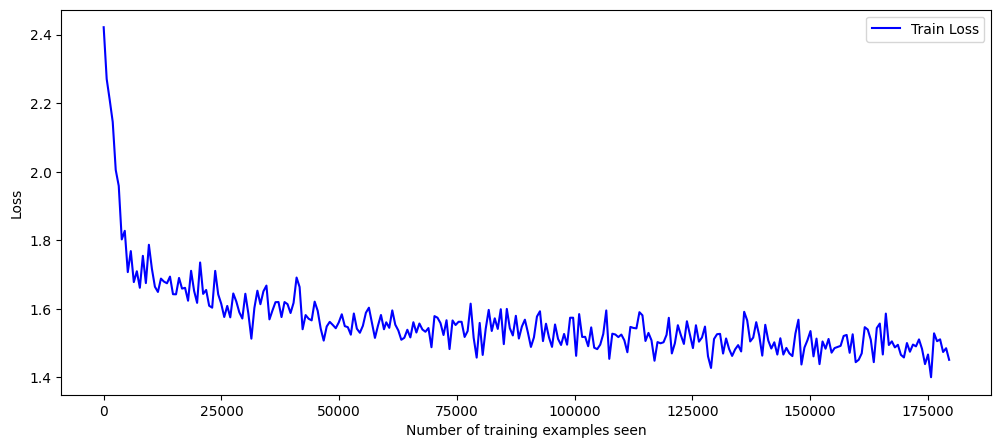

In [ ]:
# SIMPLE CNN WITH RDROP alpha = 3
model = SimpleCNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
max_epochs = 3
train_rd_model(model, optimizer, max_epochs, F.nll_loss, 3)

Epoch 1: [0/60000] Loss: 2.300
Epoch 1: [6400/60000] Loss: 2.288
Epoch 1: [12800/60000] Loss: 2.217
Epoch 1: [19200/60000] Loss: 1.302
Epoch 1: [25600/60000] Loss: 0.945
Epoch 1: [32000/60000] Loss: 0.399
Epoch 1: [38400/60000] Loss: 0.356
Epoch 1: [44800/60000] Loss: 0.263
Epoch 1: [51200/60000] Loss: 0.411
Epoch 1: [57600/60000] Loss: 0.118
Test result on epoch 1: Avg loss is 0.123, Accuracy: 96.180%
Epoch 2: [0/60000] Loss: 0.230
Epoch 2: [6400/60000] Loss: 0.186
Epoch 2: [12800/60000] Loss: 0.274
Epoch 2: [19200/60000] Loss: 0.147
Epoch 2: [25600/60000] Loss: 0.157
Epoch 2: [32000/60000] Loss: 0.107
Epoch 2: [38400/60000] Loss: 0.105
Epoch 2: [44800/60000] Loss: 0.063
Epoch 2: [51200/60000] Loss: 0.163
Epoch 2: [57600/60000] Loss: 0.231
Test result on epoch 2: Avg loss is 0.079, Accuracy: 97.720%
Epoch 3: [0/60000] Loss: 0.070
Epoch 3: [6400/60000] Loss: 0.051
Epoch 3: [12800/60000] Loss: 0.120
Epoch 3: [19200/60000] Loss: 0.158
Epoch 3: [25600/60000] Loss: 0.184
Epoch 3: [32000/60

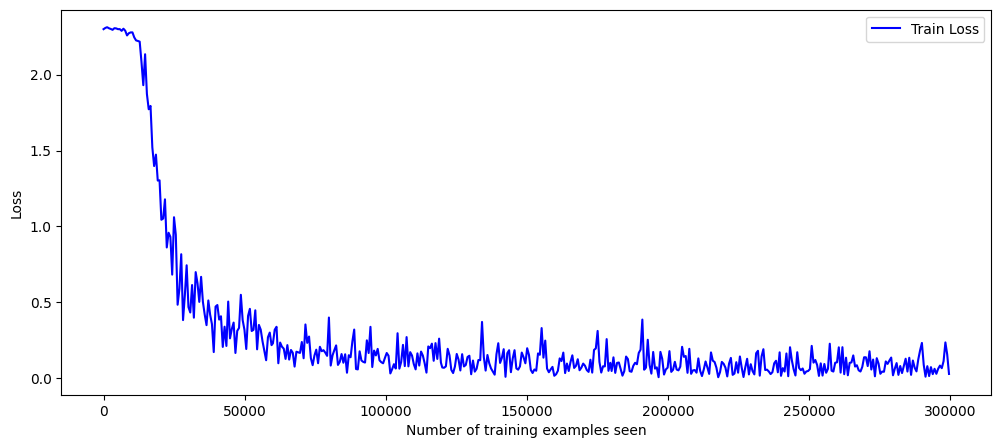

In [ ]:
# DEEPER CNN WITHOUT RDROP
model = DeeperCNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
max_epochs = 5
train_std_model(model, optimizer, max_epochs, F.nll_loss, F.nll_loss)

Epoch 1: [0/60000] Loss: 2.333
Epoch 1: [6400/60000] Loss: 2.264
Epoch 1: [12800/60000] Loss: 1.954
Epoch 1: [19200/60000] Loss: 1.705
Epoch 1: [25600/60000] Loss: 1.556
Epoch 1: [32000/60000] Loss: 1.379
Epoch 1: [38400/60000] Loss: 1.302
Epoch 1: [44800/60000] Loss: 1.333
Epoch 1: [51200/60000] Loss: 1.302
Epoch 1: [57600/60000] Loss: 1.194
Test result on epoch 1: Avg loss is 0.397, Accuracy: 93.770%
Epoch 2: [0/60000] Loss: 1.157
Epoch 2: [6400/60000] Loss: 1.117
Epoch 2: [12800/60000] Loss: 1.171
Epoch 2: [19200/60000] Loss: 1.141
Epoch 2: [25600/60000] Loss: 1.180
Epoch 2: [32000/60000] Loss: 1.249
Epoch 2: [38400/60000] Loss: 1.115
Epoch 2: [44800/60000] Loss: 1.022
Epoch 2: [51200/60000] Loss: 1.246
Epoch 2: [57600/60000] Loss: 1.126
Test result on epoch 2: Avg loss is 0.168, Accuracy: 96.220%
Epoch 3: [0/60000] Loss: 1.059
Epoch 3: [6400/60000] Loss: 1.019
Epoch 3: [12800/60000] Loss: 1.075
Epoch 3: [19200/60000] Loss: 1.083
Epoch 3: [25600/60000] Loss: 1.005
Epoch 3: [32000/60

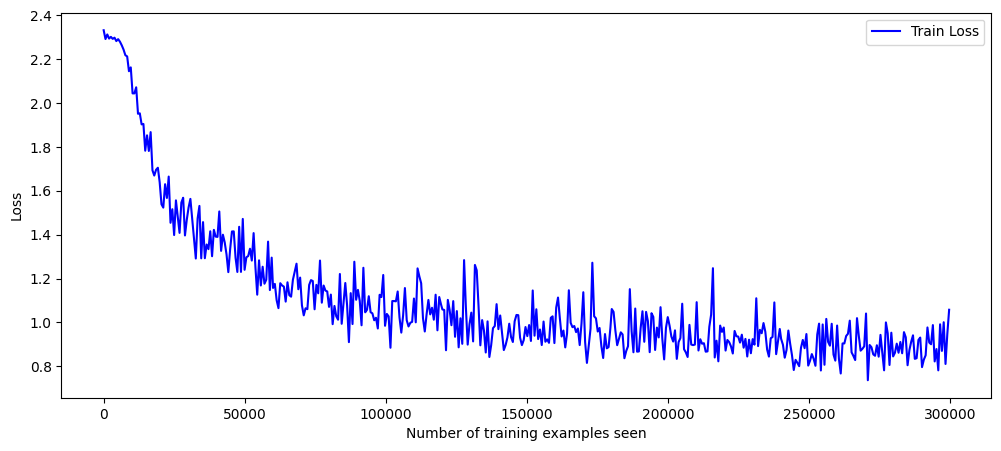

In [ ]:
# DEEPER CNN WITH RDROP alpha = 1
model = DeeperCNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
max_epochs = 5
train_rd_model(model, optimizer, max_epochs, F.nll_loss, 1)